In [1]:
from autolens import conf
from autolens.autofit import non_linear as nl
from autolens.autofit import model_mapper as mm
from autolens.pipeline import phase as ph
from autolens.lensing import galaxy_model as gm
from autolens.imaging import image as im
from autolens.profiles import light_profiles as lp
from autolens.profiles import mass_profiles as mp
from autolens.plotting import fitting_plotters
from howtolens.simulations import lens_modeling as simulate

# So, we've learnt that if our parameter space is too complex, our non-linear search might fail to find the global
# maximum solution. However, we also learnt how to ensure this doesn't happen, by:

# 1) Tuning our priors to the strong lens we're fitting.
# 2) Making our lens model less complex.
# 3) Searching non-linear parameter space for longer.

# However, each of the above approaches has disadvantages. The more we tune our priors, the less we can generalize our
# analysis to a different strong lens. The less complex we make our model, the less realistic it is. And if we rely too
# much on searching parameter space for longer, we could end up with phase's that take days, weeks or months to run.

# In this exercise, we're going to combine these 3 approaches, so that we can fit complex and realistic lens
# models in a way that that can be generalized to many different strong lenses. To do this, we'll run 2 phases, and
# link the lens model inferred in the first phase to the priors of the second phase's lens model.

# Our first phase will make the same light-traces-mass assumption we made in the previous tutorial. We saw that this
# gives a reasonable lens model. However, we'll make a couple of extra simplifying assumptions, to really try and
# bring our lens model complexity down and get the non-linear search running fast.

# The model we infer above will therefore be a lot less realistic. But it doesn't matter, because in the second phase
# we're going to relax these assumptions and get back our more realistic lens model. The beauty is that, by running
# the first phase, we can use its results to tune the priors of our second phase. For example:

# 1) The first phase should give us a pretty good idea of the lens galaxy's light and mass profiles, for example its
#    intensity, effective radius and einstein radius.

# 2) It should also give us a pretty good fit to the lensed source galaxy. This means we'll already know where in
#    source-plane its is located and what its intensity and effective are.

/home/jammy/PyCharm/Projects/AutoLens/autolens/profiles/mass_profiles.py:445: RuntimeWarning: invalid value encountered in true_divide
  deflection_y = np.arctanh(np.divide(np.multiply(np.sqrt(1 - self.axis_ratio ** 2), grid[:, 0]), psi))
/home/jammy/PyCharm/Projects/AutoLens/autolens/profiles/mass_profiles.py:446: RuntimeWarning: invalid value encountered in true_divide
  deflection_x = np.arctan(np.divide(np.multiply(np.sqrt(1 - self.axis_ratio ** 2), grid[:, 1]), psi))


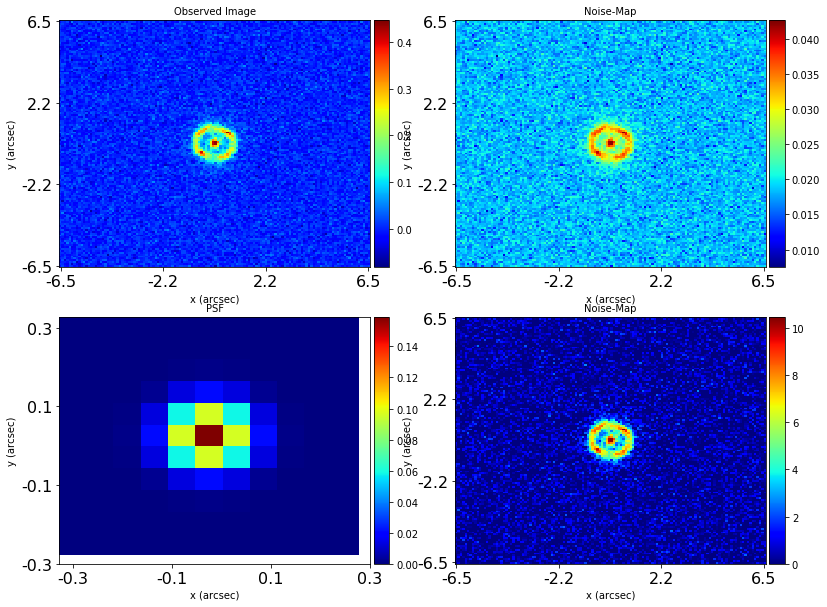

FileNotFoundError: [Errno 2] No such file or directory: '/home/jammy/PyCharm/Projects/AutoLens/howtolens/2_lens_modeling/data/3_realism_and_complexity_image.fits'

In [2]:
# As per usual, lets load the data - we'll use the same data as before, given that we're familiar with it now.
path = '/home/jammy/PyCharm/Projects/AutoLens/howtolens/2_lens_modeling'
conf.instance = conf.Config(config_path=path+'/configs/5_linking_phases', output_path=path+"/../output")
simulate.tutorial_3_image()
image = im.load_imaging_from_path(image_path=path + '/data/3_realism_and_complexity_image.fits',
                                  noise_map_path=path+'/data/3_realism_and_complexity_noise_map.fits',
                                  psf_path=path + '/data/3_realism_and_complexity_psf.fits', pixel_scale=0.1)

In [3]:
# Lets use the same LightTracesMass Phase that we did previously, but we'll make it slightly less complex then before.

class LightTracesMassPhase(ph.LensSourcePlanePhase):

    def pass_priors(self, previous_results):

        # We saw these in the previous tutorial, however I've commented them out. I'll explain why in a moment.
       # self.lens_galaxies[0].mass_centre_0 = self.lens_galaxies[0].light.centre_0
       # self.lens_galaxies[0].mass_centre_1 = self.lens_galaxies[0].light.centre_1
       # self.lens_galaxies[0].mass_axis_ratio = self.lens_galaxies[0].light.axis_ratio
       # self.lens_galaxies[0].mass_phi = self.lens_galaxies[0].light.phi

        # The example below doesnt work - BUG with model mapper.

        # As we've eluded to before, one can look at an image and immediately identify the centre of the lens
        # galaxy. It's that bright blob of light surrounded by the lensed source galaxy! Given that we know we're going
        # to make the lens model more complex in the next phase, lets take a liberal approach to the lens centre and
        # fix it to (x,y) = (0.0", 0.0").

        # You haven't actually seen a line like this one before. By setting a parameter to a number (and not a prior),
        # it is be removed rom non-linear parameter space and always fixed to that value. Pretty neat, huh?
        # self.lens_galaxies[0].mass_centre_0 = 0.0
        # self.lens_galaxies[0].mass_centre_1 = 0.0

        # Now, you might be thinking, doesn't this prevent our phase from generalizing to other strong lenses?
        # What if the centre of their lens galaxy isn't at (0.0", 0.0")?
        #
        # Well, this is true if our data reduction centres the lens galaxy somewhere else. But we get to choose where
        # we centre it when we make the image. Therefore, I'd recommend you always centre the lens galaxy at the same
        # location, and (0.0", 0.0") seems the best choice!

        # We also discussed that the Sersic index of most lens galaxies is around 4. Lets be liberal and fix it to
        # 4 this time.

        self.lens_galaxies[0].light.sersic_index = 4.0


In [5]:
# Now lets create the phase. You'll notice three new inputs to the lens galaxy's model - 'align_centres', 
# 'align_axis_ratios' and  'align_orientation'. These functions align the centres, axis_ratio and phi values of the 
# lens galaxy's light and mass profiles, just like we did in the previous phase. This is a lot easier than writing out
# the lines that I commented out the lines above, so view these inputs as a convinience.  
phase_1 = LightTracesMassPhase(lens_galaxies=[gm.GalaxyModel(light=lp.EllipticalSersic, mass=mp.EllipticalIsothermal,
                                                             align_centres=True, align_axis_ratios=True,
                                                             align_orientations=True)],
                               source_galaxies=[gm.GalaxyModel(light=lp.EllipticalExponential)],
                               optimizer_class=nl.MultiNest, 
                               phase_name='2_lens_modeling/5_linking_phase_1')

In [6]:
# Lets go one step further. Now we know our parameter space is less complex, maybe we can find the maximum likelihood
# with fewer MultiNest live points and a faster sampling rate?
phase_1.optimizer.n_live_points = 30
phase_1.optimizer.sampling_efficiency = 0.9

In [7]:
# Lets run the phase, noting that our liberal approach to reducing the lens model complexity has reduced it to just
# 11 parameters. (The results are still preloaded for you, but feel free to run it yourself, its fairly quick).
phase_1_results = phase_1.run(image=image)


NameError: name 'image' is not defined

In [8]:
# And indeed, we get a reasonably good model and fit to the data - in a much shorter space of time!
fitting_plotters.plot_fitting_subplot(fit=phase_1_results.fit)

AttributeError: module 'autolens.plotting.fitting_plotters' has no attribute 'plot_fitting'

In [ ]:
# Now all we need to do is look at the results of phase 1 and tune our priors in phase 2 to those results. Lets
# setup a custom phase that does exactly that.
#
# GaussianPriors are a nice way to do this. They tell the non-linear search where to look, but leave open the
# possibility that there might be a better solution nearby. In contrast, UniformPriors puts hard limits on what
# values a parameter can or can't take - it makes it more likely we'll accidently cut-out the global likelihood solution.

class CustomPriorPhase(ph.LensSourcePlanePhase):

    def pass_priors(self, previous_results):

        # What I've done here is looked at the results of phase 1, and manually specified a prior for every parameter.
        # If a parameter was fixed in the previous phase, its prior is based around the previous value. Don't worry
        # about the sigma values for now, I've chosen values that I know will ensure reasonable sampling, but we'll
        # cover this later.

        self.lens_galaxies[0].light.centre_0 = mm.GaussianPrior(mean=0.0, sigma=0.1)
        self.lens_galaxies[0].light.centre_1 = mm.GaussianPrior(mean=0.0, sigma=0.1)
        self.lens_galaxies[0].light.axis_ratio = mm.GaussianPrior(mean=0.8, sigma=0.15)
        self.lens_galaxies[0].light.phi = mm.GaussianPrior(mean=45.0, sigma=15.0)
        self.lens_galaxies[0].light.intensity = mm.GaussianPrior(mean=0.02, sigma=0.01)
        self.lens_galaxies[0].light.effective_radius = mm.GaussianPrior(mean=0.62, sigma=0.2)
        self.lens_galaxies[0].light.sersic_index = mm.GaussianPrior(mean=4.0, sigma=2.0)

        self.lens_galaxies[0].mass.centre_0 = mm.GaussianPrior(mean=0.0, sigma=0.1)
        self.lens_galaxies[0].mass.centre_1 = mm.GaussianPrior(mean=0.0, sigma=0.1)
        self.lens_galaxies[0].mass.axis_ratio = mm.GaussianPrior(mean=0.8, sigma=0.25)
        self.lens_galaxies[0].mass.phi = mm.GaussianPrior(mean=45.0, sigma=30.0)
        self.lens_galaxies[0].mass.einstein_radius = mm.GaussianPrior(mean=0.8, sigma=0.1)

        self.source_galaxies[0].light.centre_0 = mm.GaussianPrior(mean=0.0, sigma=0.1)
        self.source_galaxies[0].light.centre_0 = mm.GaussianPrior(mean=0.0, sigma=0.1)
        self.source_galaxies[0].light.axis_ratio = mm.GaussianPrior(mean=0.8, sigma=0.1)
        self.source_galaxies[0].light.phi = mm.GaussianPrior(mean=90.0, sigma=10.0)
        self.source_galaxies[0].light.intensity = mm.GaussianPrior(mean=0.14, sigma=0.05)
        self.source_galaxies[0].light.effective_radius = mm.GaussianPrior(mean=0.12, sigma=0.2)


In [ ]:
# Lets setup and run the phase. As expected, it gives us the correct lens model. However, it does so significantly
# faster than we're used to - I'd actually recommend you run this phase yourself! (Although I have provided the model
# for the eager amongst you).
phase_2 = CustomPriorPhase(lens_galaxies=[gm.GalaxyModel(light=lp.EllipticalSersic, mass=mp.EllipticalIsothermal)],
                           source_galaxies=[gm.GalaxyModel(light=lp.EllipticalExponential)],
                           optimizer_class=nl.MultiNest, phase_name='5_linking_phase_2')
phase_2.optimizer.n_live_points = 30
phase_2.optimizer.sampling_efficiency = 0.9
phase_2_results = phase_2.run(image=image)

In [ ]:
# Look at that, the right lens model, again!
fitting_plotters.plot_fitting_subplot(fit=phase_1_results.fit)

In [ ]:
# Our choice to link two phases together was a huge success. We managed to fit a complex and realistic model,
# but were able to begin by making simplifying assumptions that eased our search of non-linear parameter space. We
# could apply phase 1 to pretty much any strong lens, and therefore get ourselves a decent lens model with which to
# tune phase 2's priors.

# You're probably thinking though, that there is one huge, giant, glaring flaw in all of this that I've not mentioned. 
# Phase 2 can't be generalized to another lens - it's priors are tuned to the image we fitted. If we had a lot of 
# lenses, we'd have to write a new phase_2 for every single one. This isn't ideal, is it?

# Well, let me reassure you, that PyAutoLens has you covered. In the next set of tutorials, we'll cover 'pipelines'. As
# you might of guessed, a pipeline comprises a set of phases that are linked together. This allows us to start with a
# simple, easy-to-fit lens model, and gradually makes it more complex. Crucially, as the pipeline runs, we 'feed' the
# results of previous phases through the pipeline, allowing us to tune our priors automatically, in a way that can be
# applied generically to any strong lens.

# However, before moving forward, there's one more thing we need to discuss - run-speed. Lens modeling is a 
# computationally expensive process and keeping the run times on the order of days, or less, can be tricky. I'll give 
# you a sense of how we can do that in the next exercise. Before that, think about this, what are the main factors 
# driving a phase's run-time?